# Relations réciproques entres personnes et avec les institutions

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itables import init_notebook_mode, show
import numpy as np
import seaborn as sns
from netgraph import Graph, InteractiveGraph
from pyvis.network import Network

## Production des données

* Requête exécutée sur le serveur https://dbpedia.org/sparql 
* Période élargie jusqu'aux comtemporains-nes
* Propriétés prises en compte après inspection des propriétés de la population:
  * http://dbpedia.org/ontology/almaMater 
  * http://dbpedia.org/ontology/institution


```SPARQL
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
SELECT DISTINCT (?o1 AS ?subject_uri) ?subjectBirthDate ?r_property  ?target 
# (COUNT(*) AS ?effectif) 
WHERE {
  SELECT DISTINCT ?o1 ?subjectBirthDate ?r_property  ?target 
  WHERE { 
    {
          {dbr:List_of_astronomers ?p ?o1.}
      UNION
          {dbr:List_of_astrologers ?p ?o1.}
      UNION
          {?o1 ?p dbr:Astrologer.}
      UNION
          {?o1 ?p dbr:Astronomer.}
      UNION
          {?o1 ?p dbr:Mathematician.}
    }
    ?o1 a dbo:Person;
      dbp:birthDate | dbo:birthDate ?subjectBirthDate.
     {
        {?o1 dbo:almaMater ?target.
     BIND('almaMater' AS ?r_property) }
UNION  {?o1 dbo:institution ?target.
     BIND('institution' AS ?r_property) }
#UNION  {?o1 dbp:fields ?target.
#     BIND('fields' AS ?r_property) }
#UNION  {?o1 dbp:field ?target.
#     BIND('field' AS ?r_property) }
}

    BIND(xsd:integer(SUBSTR(STR(?subjectBirthDate), 1, 4)) AS ?birthYear)
    FILTER ( (?birthYear >= 1451   ))
 
          }
  ORDER BY ?birthYear
  }

```

In [2]:
### Ouvrir le fichier et créer un DataFrame
fd = 'data/dbpedia_sparql_relations.csv'
df = pd.read_csv(fd)
len(df)

7136

In [3]:
### Raccourcir l'URI, extraire l'année de naissance
df['subject_uri'] = df['subject_uri'].apply(lambda x : x.replace('http://dbpedia.org/resource/', ''))
df['target'] = df['target'].apply(lambda x : x.replace('http://dbpedia.org/resource/', ''))
df['BirthYear'] = df['subjectBirthDate'].apply(lambda x : int(x[:4]))

In [4]:
### Ajouter deux périodes différentes en fonctions de la relation
# Pour la relation 'étudier' créer une période entre 18 et 28 ans (+17, +27) pour l'étendue des études
# Pour la relation 'insitution' ajouté une période d'activité de 19 à 65 ans
df['YBegin'] = df[['BirthYear', 'r_property']].apply(lambda x : int(x['BirthYear'] + 17) if x['r_property'] == 'almaMater' else int(x['BirthYear'] + 27), axis=1)
df['YEnd'] = df[['BirthYear', 'r_property']].apply(lambda x : int(x['BirthYear'] + 28) if x['r_property'] == 'almaMater' else int(x['BirthYear'] + 64), axis=1)

In [5]:
### Inspecter DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7136 entries, 0 to 7135
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   subject_uri       7136 non-null   object
 1   subjectBirthDate  7136 non-null   object
 2   r_property        7136 non-null   object
 3   target            7136 non-null   object
 4   BirthYear         7136 non-null   int64 
 5   YBegin            7136 non-null   int64 
 6   YEnd              7136 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 390.4+ KB


In [6]:
### Inspecter la distribution des années de naissance
df.BirthYear.describe()

count    7136.000000
mean     1913.805914
std        55.868705
min      1454.000000
25%      1899.000000
50%      1926.000000
75%      1947.000000
max      1989.000000
Name: BirthYear, dtype: float64

In [7]:
### Inspecter la table 
# https://github.com/mwouts/itables/blob/main/docs/advanced_parameters.md
show(df[['subject_uri','r_property','target','YBegin','YEnd','BirthYear']].sort_values(by='BirthYear'), classes="display", scrollY="200px", 
     scrollCollapse=True, paging=False, column_filters="footer", dom="lrtip")

In [8]:
### Compter par propriété
df.groupby(by='r_property').size()

r_property
almaMater      4103
institution    3033
dtype: int64

In [10]:
# l_org_orig = list(df.target.unique()); len(l_org_orig), l_org_orig[:3]

In [9]:
### Effectuer et documenter tous les changements: nettoyage des données
df.loc[df.target == 'École_normale_supérieure_(Ulm)', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'École_normale_supérieure', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'École_Normale_Supérieure', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'École_Normale_Superieure', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'Swiss_Federal_Polytechnic', 'target']  = 'ETH_Zürich'
df.loc[df.target == 'Federal_Polytechnic_School', 'target']  = 'ETH_Zürich'
df.loc[df.target == 'Swiss_Federal_Institute_of_Technology_at_Zurich', 'target']  = 'ETH_Zürich'
df.loc[df.target == 'École_polytechnique', 'target']  = 'École_Polytechnique'
df.loc[df.target == 'University_of_Padua', 'target']  = 'Università_di_Padova'
df.loc[df.target == 'University_of_Padova', 'target']  = 'Università_di_Padova'

In [10]:
### Remplacements multiples, contenant Paris et Université
df.loc[(df.target.str.contains('Paris')) & (df.target.str.contains('Univ')), 'target'] = "Université_de_Paris"

In [11]:
organisations = df.groupby(by='target').size()
show(organisations.sort_index(ascending=False))

In [17]:
### Effectif total et les plus représentées
len(organisations), organisations.sort_values(ascending=False).head(10)

(1677,
 target
 Harvard_University                       185
 Princeton_University                     178
 University_of_Cambridge                  173
 Université_de_Paris                      159
 Moscow_State_University                  122
 University_of_Chicago                    121
 University_of_California,_Berkeley       114
 Massachusetts_Institute_of_Technology    112
 University_of_Michigan                    89
 University_of_Göttingen                   87
 dtype: int64)

### Explorer les années de naissance

In [18]:
s = df.BirthYear

(1801.0, 1900.0)

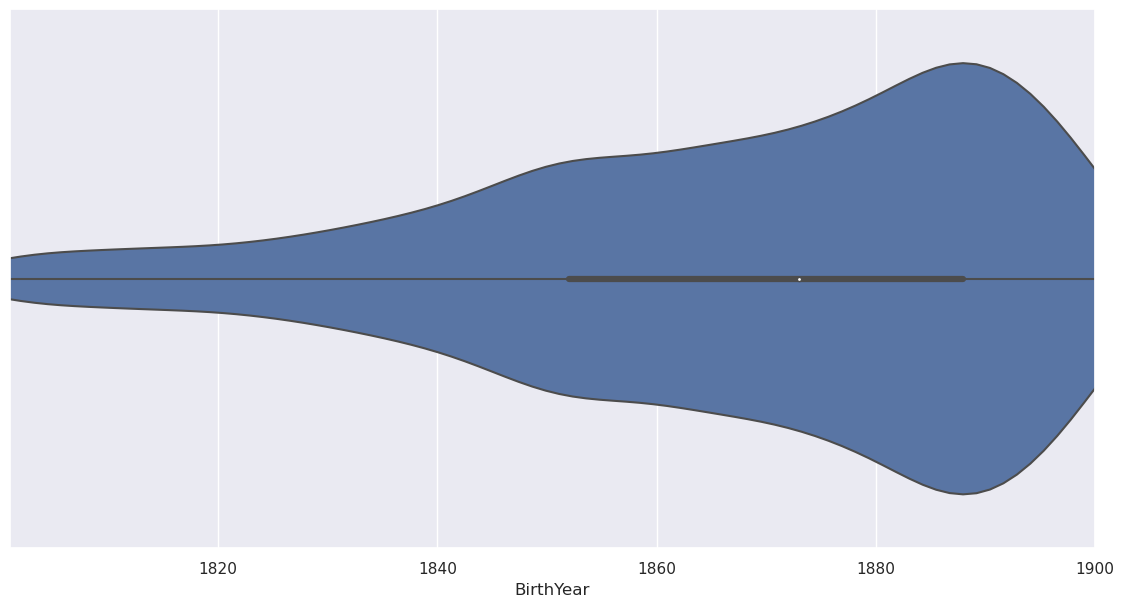

In [140]:
### Violinplot : densité des naissances dans le temps
#  https://mode.com/blog/violin-plot-examples/
#  https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot

sns.set_theme(style="whitegrid")

sns.set(rc={"figure.figsize":(14, 7)})

### Personnes nées avant 1931 (protection des données)
# a = s[(s<1931)] 
## Période pré-scientifique
a = s[(s<1801)]
## Décollage de la science 'moderne'
a = s[(s>1800) & (s<1901)] # 
## Science contemporaine
# a = s[(s>1900) ] # 
lim_left=min(a)
lim_right=max(a)





ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=lim_left, right=lim_right)


#### Coder les périodes

In [13]:
bins=[1001,1801,1901,2021]

In [14]:
df['periode'] = pd.cut(df['BirthYear'], bins=bins, right=False  )
df.periode = df.periode.apply( lambda x : str(x.left) + '_' + str(x.right))

In [15]:
df.head()

subject_uri subjectBirthDate r_property  \
0  Domenico_Maria_Novara_da_Ferrara       1454-08-01  almaMater   
1                Scipione_del_Ferro       1465-02-06  almaMater   
2        Heinrich_Cornelius_Agrippa       1486-09-14  almaMater   
3                    Michael_Stifel             1487  almaMater   
4                  Gerolamo_Cardano       1501-09-24  almaMater   

                     target  BirthYear  YBegin  YEnd    periode  
0    University_of_Florence       1454    1471  1482  1001_1801  
1     University_of_Bologna       1465    1482  1493  1001_1801  
2     University_of_Cologne       1486    1503  1514  1001_1801  
3  University_of_Wittenberg       1487    1504  1515  1001_1801  
4       University_of_Pavia       1501    1518  1529  1001_1801

In [16]:
### Effectif par période
df.groupby(by='periode').size()

periode
1001_1801     256
1801_1901    1578
1901_2021    5302
dtype: int64

In [17]:
### Dataframe to dictionary
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_dict.html
ldf = df[['subject_uri', 'r_property', 'target',
       'YBegin', 'YEnd', 'BirthYear', 'periode']].sort_values(by='subject_uri').to_dict('records')

In [18]:
ldf[:2]

[{'subject_uri': "'Mamphono_Khaketla",
  'r_property': 'almaMater',
  'target': 'University_of_Wisconsin',
  'YBegin': 1977,
  'YEnd': 1988,
  'BirthYear': 1960,
  'periode': '1901_2021'},
 {'subject_uri': 'A._E._Douglass',
  'r_property': 'almaMater',
  'target': 'Hartford',
  'YBegin': 1884,
  'YEnd': 1895,
  'BirthYear': 1867,
  'periode': '1801_1901'}]

## Graphe à deux types de sommets


Il s'agit d'un graphe de type 'bipartite', cf. la documentation de Networkx:

https://networkx.org/documentation/stable/reference/algorithms/bipartite.html

Nous n'utilisons toutefois pas ici les fonctions spécifiques de Neworkx.

In [147]:
l = []
for i in ldf:
    if i['periode'] == '1001_1801':
        l.append(tuple((i['subject_uri'],i['target'], 
                        {'relationship': i['r_property'], "birth_year": i['BirthYear'], "periode": i['periode'] })))
l[:5]

[('Abraham_de_Moivre',
  'Academy_of_Saumur',
  {'relationship': 'almaMater', 'birth_year': 1667, 'periode': '1001_1801'}),
 ('Adolphe_Quetelet',
  'University_of_Ghent',
  {'relationship': 'almaMater', 'birth_year': 1796, 'periode': '1001_1801'}),
 ('Adriaan_Metius',
  'University_of_Franeker',
  {'relationship': 'almaMater', 'birth_year': 1571, 'periode': '1001_1801'}),
 ('Adrien-Marie_Legendre',
  'Collège_Mazarin',
  {'relationship': 'almaMater', 'birth_year': 1752, 'periode': '1001_1801'}),
 ('Anders_Celsius',
  'Uppsala_University',
  {'relationship': 'almaMater', 'birth_year': 1701, 'periode': '1001_1801'})]

In [148]:
# Graphe Personne- Organisation
POG=nx.Graph()

In [149]:
POG.add_edges_from(l)

In [150]:
### Principales caractéristiques de ce graphe

POG.is_multigraph(), POG.is_directed(), nx.is_connected(POG), POG.number_of_nodes(), POG.number_of_edges(), nx.density(POG)


(False, False, False, 313, 241, 0.004935692635373147)

In [151]:
### Créer une liste des organisations
l_org = list(organisations.index); len(l_org); l_org[:3]

['AT&T_Bell_Laboratories', 'AT&T_Labs', 'Aarhus_University']

In [152]:
list(POG.nodes.data())[:4]

[('Abraham_de_Moivre', {}),
 ('Academy_of_Saumur', {}),
 ('Adolphe_Quetelet', {}),
 ('University_of_Ghent', {})]

In [153]:
### Ajouter au sommets un code si personne ou organisation
# On utiliser pour ce faire la liste des organisations
types = {}
for e in list(POG.nodes):
    if e in l_org:
        t = 'O'
    else:
        t = 'P'
    types[e] = {'type': t} 
[(k,v )for k,v in types.items()][:3]  

[('Abraham_de_Moivre', {'type': 'P'}),
 ('Academy_of_Saumur', {'type': 'O'}),
 ('Adolphe_Quetelet', {'type': 'P'})]

In [154]:
nx.set_node_attributes(POG, types)
list(POG.nodes.data())[:3]

[('Abraham_de_Moivre', {'type': 'P'}),
 ('Academy_of_Saumur', {'type': 'O'}),
 ('Adolphe_Quetelet', {'type': 'P'})]

### Inspecter les centralités de degré

In [155]:
### Ajouter la centralité de degré
# grâce à un dictionnaire construit selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(POG)])

In [156]:
nx.set_node_attributes(POG, degree)

In [157]:
print(list(POG.nodes.data())[:4])

[('Abraham_de_Moivre', {'type': 'P', 'degree': 1}), ('Academy_of_Saumur', {'type': 'O', 'degree': 1}), ('Adolphe_Quetelet', {'type': 'P', 'degree': 1}), ('University_of_Ghent', {'type': 'O', 'degree': 1})]


In [158]:
persons_degree = []
for n in list(POG.nodes.data()):
    if n[1]['type'] == 'P':
        persons_degree.append([n[0], n[1]['degree']])

In [159]:
sorted(persons_degree, key = lambda x : x[1], reverse=True)[:10]

[['Joseph_Johann_von_Littrow', 6],
 ['Andreas_von_Ettingshausen', 3],
 ['Carl_Friedrich_Gauss', 3],
 ['David_Gregory_(mathematician)', 3],
 ['Denison_Olmsted', 3],
 ['Geminiano_Montanari', 3],
 ['Gilles_de_Roberval', 3],
 ['Isaac_Newton', 3],
 ['James_Ivory_(mathematician)', 3],
 ['Jean-Alfred_Gautier', 3]]

In [160]:
org_degree = []
for n in list(POG.nodes.data()):
    if n[1]['type'] == 'O':
        org_degree.append([n[0], n[1]['degree']])

In [161]:
sorted(org_degree, key = lambda x : x[1], reverse=True)[:10]

[['Trinity_College,_Cambridge', 14],
 ['École_Polytechnique', 13],
 ['University_of_Göttingen', 8],
 ['Università_di_Padova', 7],
 ['University_of_Pisa', 6],
 ["St_John's_College,_Cambridge", 6],
 ['University_of_Edinburgh', 6],
 ['University_of_Copenhagen', 5],
 ['University_of_Bologna', 5],
 ['University_of_Geneva', 4]]

In [162]:
edges = list(POG.edges.data())
edges[:5]

[('Abraham_de_Moivre',
  'Academy_of_Saumur',
  {'relationship': 'almaMater', 'birth_year': 1667, 'periode': '1001_1801'}),
 ('Adolphe_Quetelet',
  'University_of_Ghent',
  {'relationship': 'almaMater', 'birth_year': 1796, 'periode': '1001_1801'}),
 ('Adriaan_Metius',
  'University_of_Franeker',
  {'relationship': 'almaMater', 'birth_year': 1571, 'periode': '1001_1801'}),
 ('Adrien-Marie_Legendre',
  'Collège_Mazarin',
  {'relationship': 'almaMater', 'birth_year': 1752, 'periode': '1001_1801'}),
 ('Anders_Celsius',
  'Uppsala_University',
  {'relationship': 'almaMater', 'birth_year': 1701, 'periode': '1001_1801'})]

In [163]:
labels = {}    
for node in POG.nodes():
    labels[node] = node

In [164]:
nx.set_node_attributes(POG, labels, 'label')

In [165]:
nodes = list(POG.nodes.data())
nodes[:5]

[('Abraham_de_Moivre',
  {'type': 'P', 'degree': 1, 'label': 'Abraham_de_Moivre'}),
 ('Academy_of_Saumur',
  {'type': 'O', 'degree': 1, 'label': 'Academy_of_Saumur'}),
 ('Adolphe_Quetelet', {'type': 'P', 'degree': 1, 'label': 'Adolphe_Quetelet'}),
 ('University_of_Ghent',
  {'type': 'O', 'degree': 1, 'label': 'University_of_Ghent'}),
 ('Adriaan_Metius', {'type': 'P', 'degree': 1, 'label': 'Adriaan_Metius'})]

### Analyser les composantes du graphe

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [166]:
components = nx.connected_components(POG);
components_l = [len(c) for c in sorted(nx.connected_components(POG), key=len, reverse=True)]
len(components_l), components_l[:5]

(75, [24, 22, 17, 15, 14])

In [167]:
S = [POG.subgraph(c).copy() for c in nx.connected_components(POG)]

In [168]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]

[[14, 24], [8, 22], [18, 17], [15, 15], [31, 14], [17, 12], [6, 11], [21, 10]]

In [169]:
li=[n[0] for n in ln]

In [170]:
S[21].nodes 

NodeView(('Peterhouse,_Cambridge', 'Josef_de_Mendoza_y_Ríos', 'Christopher_Heydon', 'University_of_Cambridge', 'Isaac_Newton', 'Jeremiah_Horrocks', 'Isaac_Milner', 'Royal_Society', 'Royal_Mint', 'William_Hopkins'))

### Représenter le graphe

In [171]:
u = S[14]

In [172]:
u = nx.Graph()
for i in li[:5]:
    u = nx.union(u, S[i])
type(u)    

networkx.classes.graph.Graph

In [173]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975)
u.is_multigraph(), u.is_directed(), u.number_of_nodes(), u.number_of_edges(), nx.density(u)


(False, False, 92, 89, 0.021261347348303872)

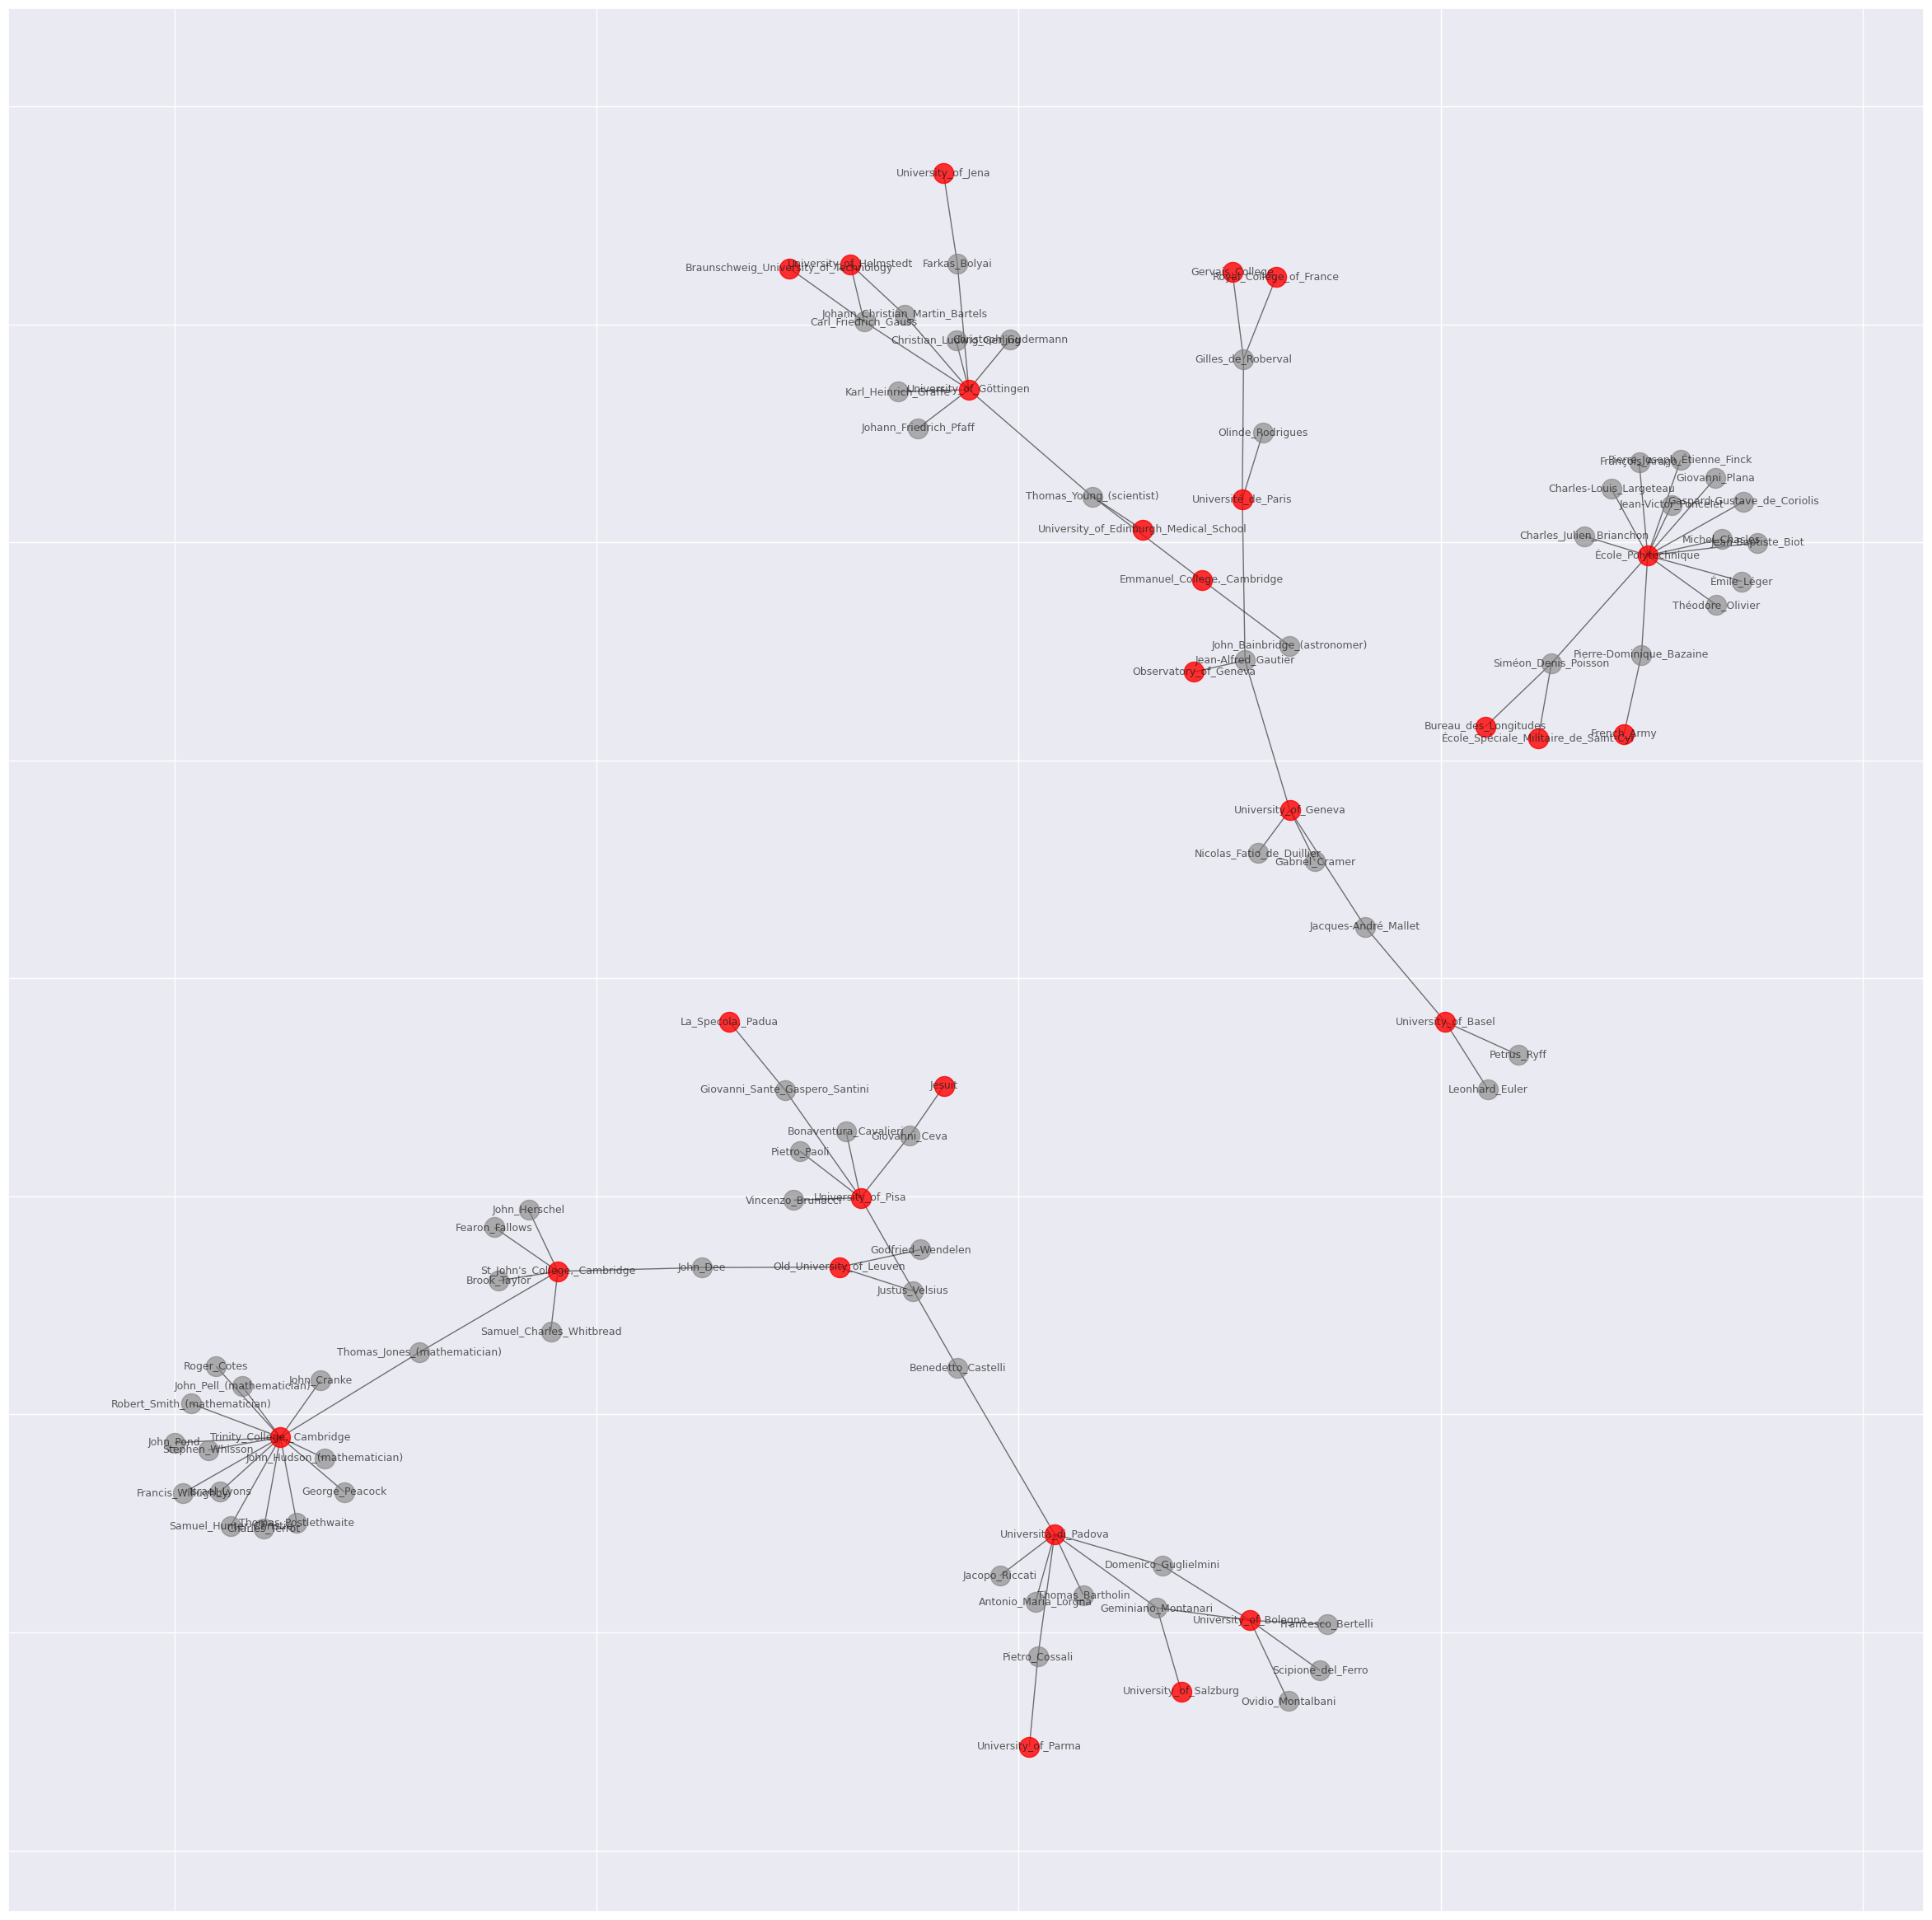

In [174]:
### Visualiser les "écoles", i.e. quelles personnes 
# ont étudié dans la même Université
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (30,30))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)

no = [x for x,y in g.nodes(data=True) if y['type']=='O']
np = [x for x,y in g.nodes(data=True) if y['type']=='P'] 

co = 'red'
cp = 'grey'
nx.draw_networkx_nodes(g, pos, nodelist=np, node_color=cp, alpha=0.6)
nx.draw_networkx_nodes(g, pos, nodelist=no, node_color=co, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=9)


plt.show()


In [175]:
### 
# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
nt = Network( notebook=True) #, filter_menu=True)
# populates the nodes and edges data structures
nt.from_nx(g)

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [176]:
nt.prep_notebook()
nt.show('pictures/nx.html' )

### Créer les paires de personnes

Personnes ayant étudié dans la même univerisité, à la même époque:

* on teste si c'est la même université
* on teste s'il y a superposition des périodes

In [19]:
### Pairs de personnes
pairs_p = []

for s1 in ldf:
    for s2 in ldf:
        if s1['subject_uri'] < s2['subject_uri'] \
            and s1['target'] == s2['target'] \
            and s2['YEnd'] > s1['YBegin'] \
            and s2['YBegin'] < s1['YEnd']:
            pairs_p.append([s1,s2])
        else:
            pass

In [20]:
len(pairs_p)

47266

In [21]:
pairs_p[:2]

[[{'subject_uri': "'Mamphono_Khaketla",
   'r_property': 'almaMater',
   'target': 'University_of_Wisconsin',
   'YBegin': 1977,
   'YEnd': 1988,
   'BirthYear': 1960,
   'periode': '1901_2021'},
  {'subject_uri': 'Marvin_Knopp',
   'r_property': 'institution',
   'target': 'University_of_Wisconsin',
   'YBegin': 1960,
   'YEnd': 1997,
   'BirthYear': 1933,
   'periode': '1901_2021'}],
 [{'subject_uri': 'A._M._Mathai',
   'r_property': 'institution',
   'target': 'McGill_University',
   'YBegin': 1962,
   'YEnd': 1999,
   'BirthYear': 1935,
   'periode': '1901_2021'},
  {'subject_uri': 'Carl_S._Herz',
   'r_property': 'institution',
   'target': 'McGill_University',
   'YBegin': 1957,
   'YEnd': 1994,
   'BirthYear': 1930,
   'periode': '1901_2021'}]]

### Créer les pairs d'organisations

Une personne fait le lien entre deux organisations

In [180]:
## Pairs d'organisations
pairs_o = []

for s1 in ldf:
    for s2 in ldf:
        if s1['target'] < s2['target'] \
            and s1['subject_uri'] == s2['subject_uri']:
                pairs_o.append([s1,s2])
        else:
            pass

In [181]:
len(pairs_o)

8338

In [182]:
### Apparaissent des parcours de vie
pairs_o[:2]

[[{'subject_uri': 'A._E._Douglass',
   'r_property': 'almaMater',
   'target': 'Hartford',
   'YBegin': 1884,
   'YEnd': 1895,
   'BirthYear': 1867,
   'periode': '1801_1901'},
  {'subject_uri': 'A._E._Douglass',
   'r_property': 'almaMater',
   'target': 'Trinity_College_(Connecticut)',
   'YBegin': 1884,
   'YEnd': 1895,
   'BirthYear': 1867,
   'periode': '1801_1901'}],
 [{'subject_uri': 'A._M._Mathai',
   'r_property': 'institution',
   'target': 'McGill_University',
   'YBegin': 1962,
   'YEnd': 1999,
   'BirthYear': 1935,
   'periode': '1901_2021'},
  {'subject_uri': 'A._M._Mathai',
   'r_property': 'almaMater',
   'target': 'Palai',
   'YBegin': 1952,
   'YEnd': 1963,
   'BirthYear': 1935,
   'periode': '1901_2021'}]]

## Réseaux de personnes (filtres, sous-populations)

In [183]:
earlyModern_pairs = [p for p in pairs_p if ((p[0]['periode']=='1001_1801') & (p[1]['periode']=='1001_1801'))]

In [184]:
len(earlyModern_pairs), earlyModern_pairs[:3]

(144,
 [[{'subject_uri': 'Andreas_von_Ettingshausen',
    'r_property': 'institution',
    'target': 'University_of_Vienna',
    'YBegin': 1823,
    'YEnd': 1860,
    'BirthYear': 1796,
    'periode': '1001_1801'},
   {'subject_uri': 'Joseph_Johann_von_Littrow',
    'r_property': 'institution',
    'target': 'University_of_Vienna',
    'YBegin': 1808,
    'YEnd': 1845,
    'BirthYear': 1781,
    'periode': '1001_1801'}],
  [{'subject_uri': 'Andreas_von_Ettingshausen',
    'r_property': 'institution',
    'target': 'University_of_Vienna',
    'YBegin': 1823,
    'YEnd': 1860,
    'BirthYear': 1796,
    'periode': '1001_1801'},
   {'subject_uri': 'Nikolai_Brashman',
    'r_property': 'almaMater',
    'target': 'University_of_Vienna',
    'YBegin': 1813,
    'YEnd': 1824,
    'BirthYear': 1796,
    'periode': '1001_1801'}],
  [{'subject_uri': 'Andreas_von_Ettingshausen',
    'r_property': 'institution',
    'target': 'Vienna_University_of_Technology',
    'YBegin': 1823,
    'YEnd': 1860,

In [185]:
almaMater_pairs = [p for p in pairs_p if ((p[0]['r_property'] == 'almaMater') & (p[1]['r_property'] == 'almaMater'))]

In [186]:
len(almaMater_pairs), almaMater_pairs[:2]

(14151,
 [[{'subject_uri': 'A._O._L._Atkin',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1942,
    'YEnd': 1953,
    'BirthYear': 1925,
    'periode': '1901_2021'},
   {'subject_uri': 'Abdus_Salam',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1943,
    'YEnd': 1954,
    'BirthYear': 1926,
    'periode': '1901_2021'}],
  [{'subject_uri': 'A._O._L._Atkin',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1942,
    'YEnd': 1953,
    'BirthYear': 1925,
    'periode': '1901_2021'},
   {'subject_uri': 'Anthony_James_Merrill_Spencer',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1946,
    'YEnd': 1957,
    'BirthYear': 1929,
    'periode': '1901_2021'}]])

## Exploration des graphes de personnes

In [187]:
### Préparer pour créer le graphe
l = []
for i in earlyModern_pairs: #almaMater_pairs:
    l.append(tuple((i[0]['subject_uri'],i[1]['subject_uri'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}", 
                                                              'organisation': i[0]['target'] })))
l[:5]

[('Andreas_von_Ettingshausen',
  'Joseph_Johann_von_Littrow',
  {'relationship': 'institution_institution',
   'organisation': 'University_of_Vienna'}),
 ('Andreas_von_Ettingshausen',
  'Nikolai_Brashman',
  {'relationship': 'institution_almaMater',
   'organisation': 'University_of_Vienna'}),
 ('Andreas_von_Ettingshausen',
  'Nikolai_Brashman',
  {'relationship': 'institution_almaMater',
   'organisation': 'Vienna_University_of_Technology'}),
 ('Andreas_von_Ettingshausen',
  'Joseph_Johann_von_Littrow',
  {'relationship': 'almaMater_institution',
   'organisation': 'University_of_Vienna'}),
 ('Andreas_von_Ettingshausen',
  'Nikolai_Brashman',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Vienna'})]

In [188]:
EMP=nx.Graph()

In [189]:
EMP.add_edges_from(l)

In [190]:
### Principales caractéristiques de ce graphe

EMP.is_multigraph(), EMP.is_directed(), nx.is_connected(EMP), EMP.number_of_nodes(), EMP.number_of_edges(), nx.density(EMP)


(False, False, False, 74, 125, 0.04627915586819696)

In [191]:
nodes = list(EMP.nodes.data())
nodes[:5]

[('Andreas_von_Ettingshausen', {}),
 ('Joseph_Johann_von_Littrow', {}),
 ('Nikolai_Brashman', {}),
 ('Antonio_Maria_Bordoni', {}),
 ('Gabrio_Piola', {})]

In [192]:
edges = list(EMP.edges.data())
edges[:5]

[('Andreas_von_Ettingshausen',
  'Joseph_Johann_von_Littrow',
  {'relationship': 'almaMater_institution',
   'organisation': 'University_of_Vienna'}),
 ('Andreas_von_Ettingshausen',
  'Nikolai_Brashman',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Vienna'}),
 ('Joseph_Johann_von_Littrow',
  'Nikolai_Brashman',
  {'relationship': 'institution_almaMater',
   'organisation': 'University_of_Vienna'}),
 ('Antonio_Maria_Bordoni',
  'Gabrio_Piola',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Pavia'}),
 ('Archibald_Alexander',
  'Joseph_Caldwell',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'Princeton_University'})]

In [193]:
labels = {}    
for node in EMP.nodes():
    labels[node] = node

In [194]:
### 
# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
nt = Network( notebook=True) #, filter_menu=True)
# populates the nodes and edges data structures
nt.from_nx(EMP)
nt.prep_notebook()
nt.show('pictures/emp.html' )

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


### Analyser les composantes du graphe

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [195]:
components = nx.connected_components(EMP);
components_l = [len(c) for c in sorted(nx.connected_components(EMP), key=len, reverse=True)]
len(components_l), components_l[:5]

(22, [13, 12, 8, 3, 3])

In [196]:
S = [EMP.subgraph(c).copy() for c in nx.connected_components(EMP)]

In [197]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]

[[6, 13], [7, 12], [5, 8], [0, 3], [9, 3], [12, 3], [1, 2], [2, 2]]

In [198]:
li=[n[0] for n in ln]

### Représenter le graphe

In [199]:
u = nx.Graph()
for i in li[1:3]:
    u = nx.union(u, S[i])
type(u)    

networkx.classes.graph.Graph

In [204]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975)
u.is_multigraph(), u.is_directed(), u.number_of_nodes(), u.number_of_edges(), nx.density(u)


(False, False, 20, 40, 0.21052631578947367)

In [205]:
u = S[5]

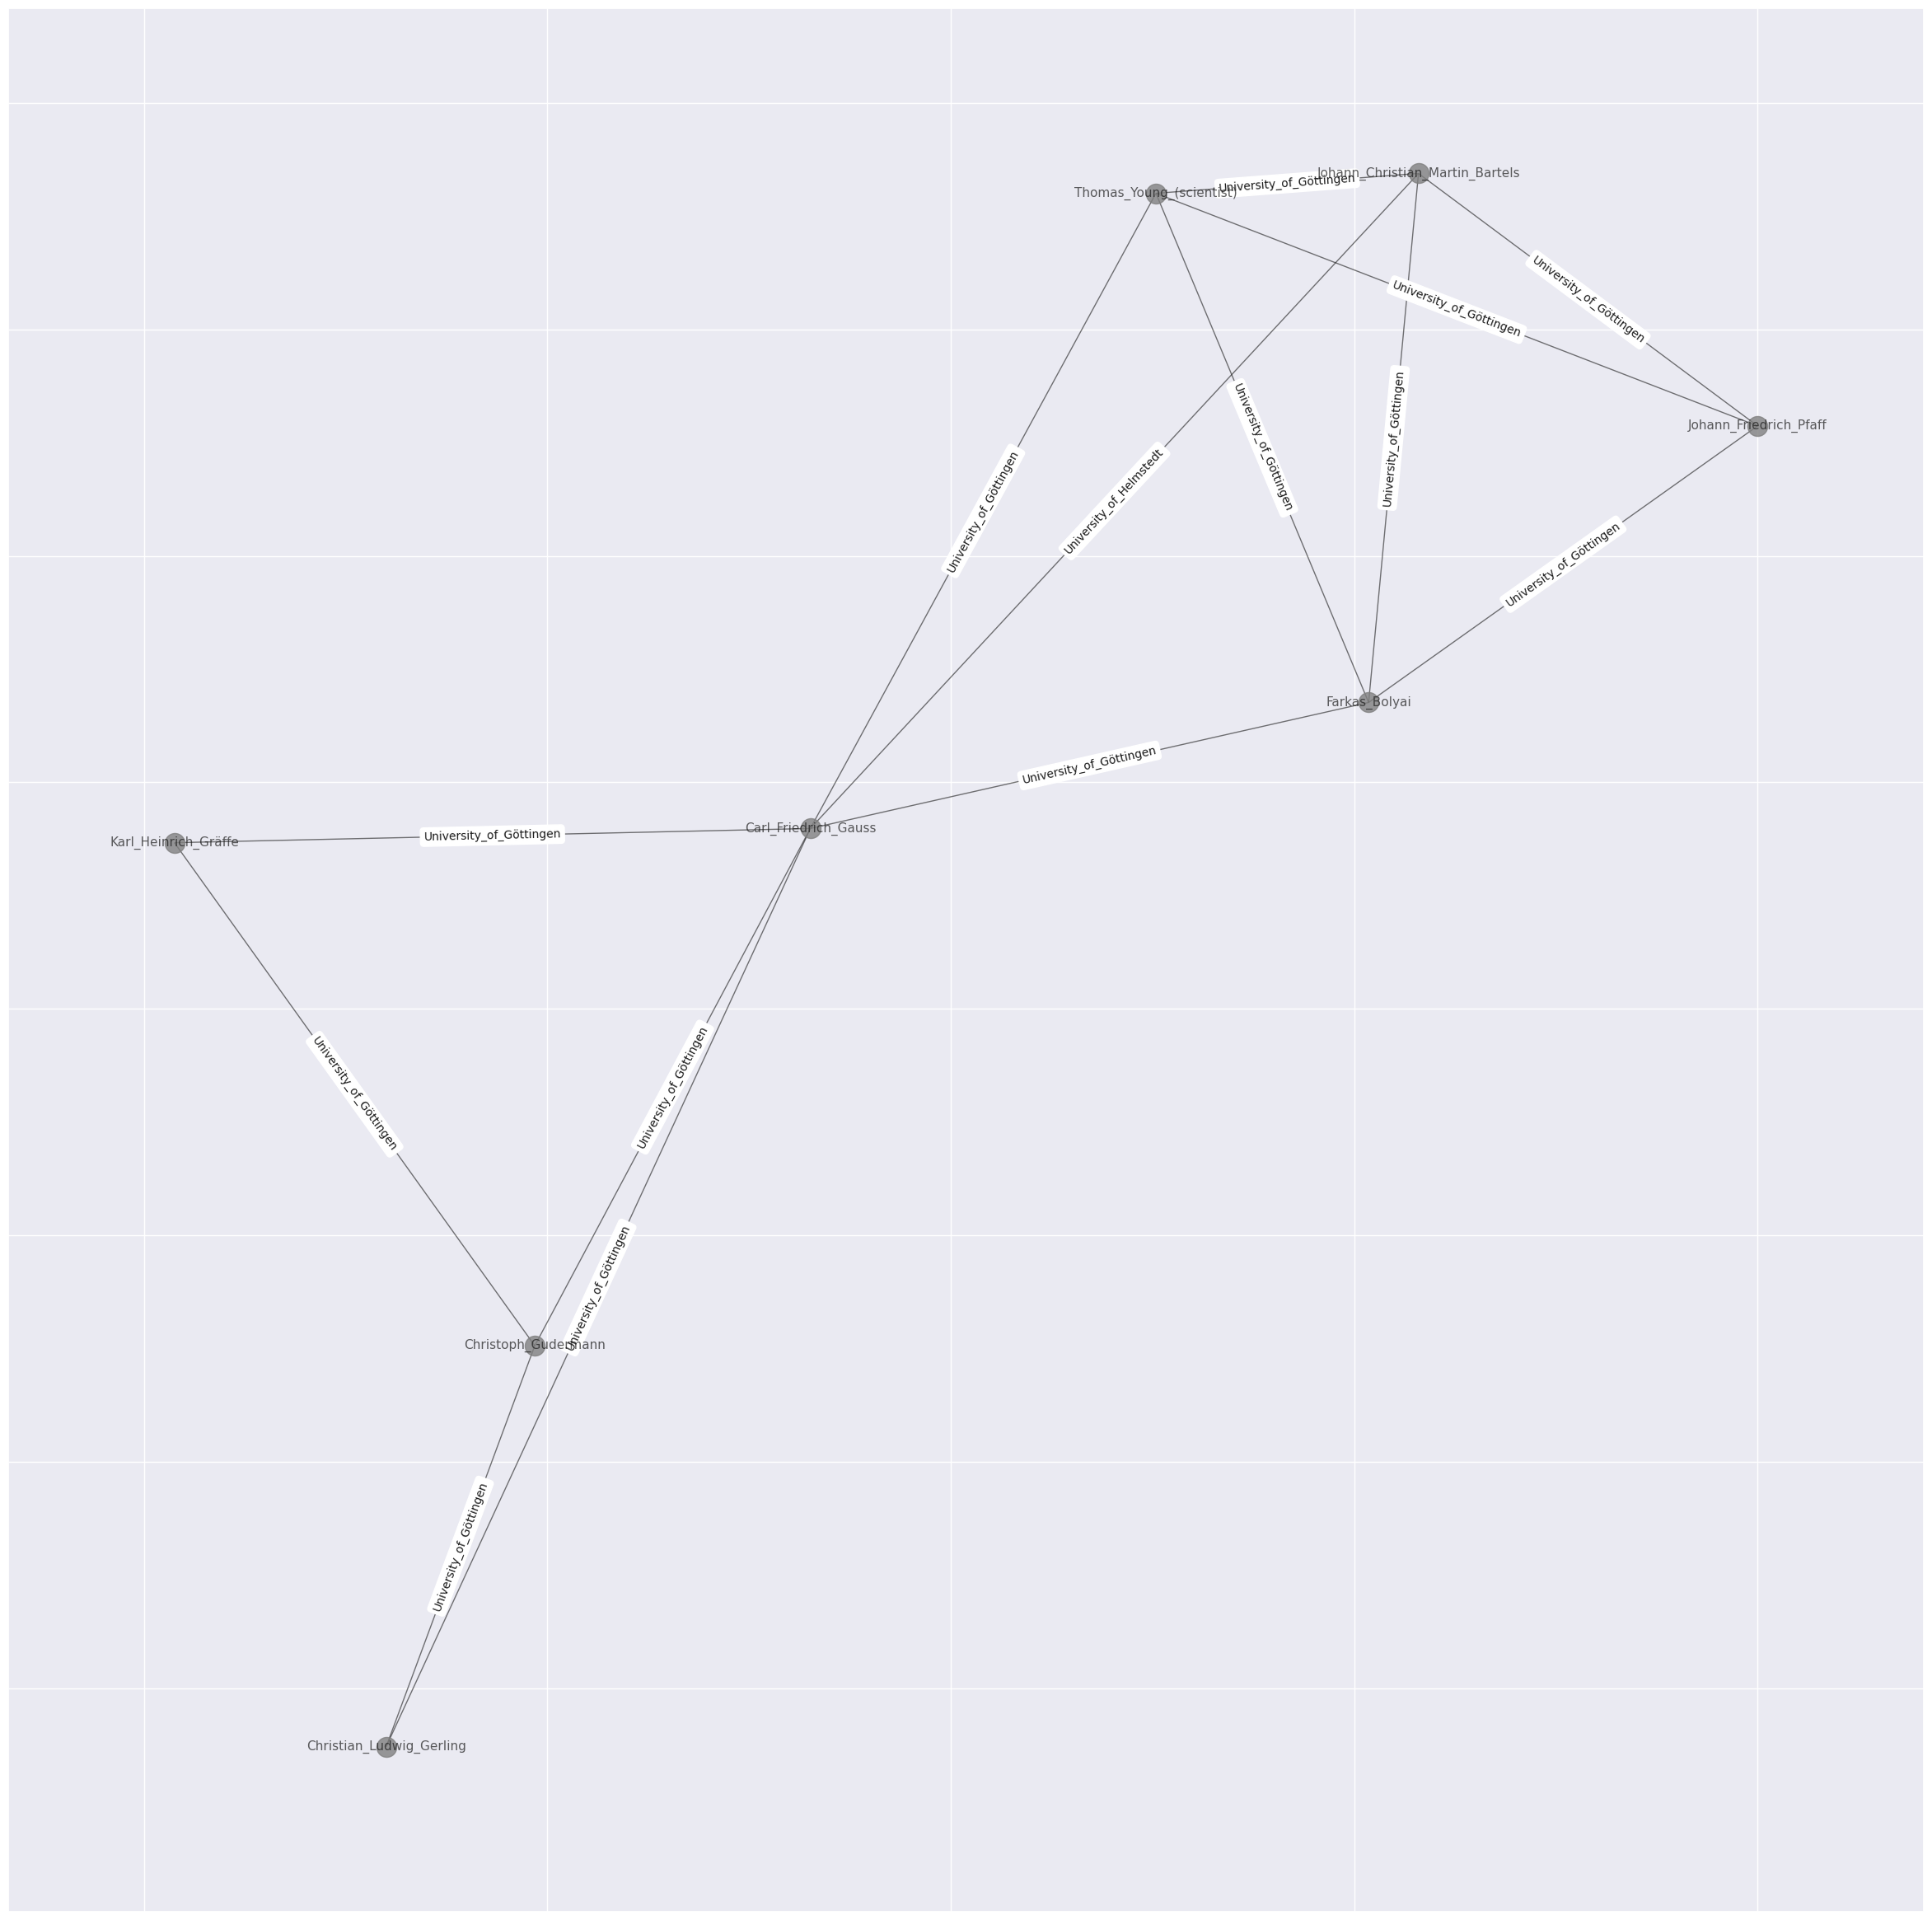

In [206]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (30,30))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
pos = nx.spring_layout(g, k=1)

labels = {e: u.get_edge_data(e[0], e[1])["organisation"] for e in u.edges()}

cp = 'grey'
nx.draw_networkx_nodes(g, pos, node_color=cp, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=11)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)



plt.show()


## Explorer le graphe des organisations (relation Alma Mater)

In [207]:
### Apparaissent des parcours de vie
pairs_o[:2]

[[{'subject_uri': 'A._E._Douglass',
   'r_property': 'almaMater',
   'target': 'Hartford',
   'YBegin': 1884,
   'YEnd': 1895,
   'BirthYear': 1867,
   'periode': '1801_1901'},
  {'subject_uri': 'A._E._Douglass',
   'r_property': 'almaMater',
   'target': 'Trinity_College_(Connecticut)',
   'YBegin': 1884,
   'YEnd': 1895,
   'BirthYear': 1867,
   'periode': '1801_1901'}],
 [{'subject_uri': 'A._M._Mathai',
   'r_property': 'institution',
   'target': 'McGill_University',
   'YBegin': 1962,
   'YEnd': 1999,
   'BirthYear': 1935,
   'periode': '1901_2021'},
  {'subject_uri': 'A._M._Mathai',
   'r_property': 'almaMater',
   'target': 'Palai',
   'YBegin': 1952,
   'YEnd': 1963,
   'BirthYear': 1935,
   'periode': '1901_2021'}]]

In [208]:
l = []
for i in pairs_o:
    if i[0]['r_property'] == 'almaMater' or  i[1]['r_property'] == 'almaMater':
        l.append(tuple((i[0]['target'],i[1]['target'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}", 
                                                              'personne': i[0]['subject_uri'] })))
len(l), l[:3]        

(5176,
 [('Hartford',
   'Trinity_College_(Connecticut)',
   {'relationship': 'almaMater_almaMater', 'personne': 'A._E._Douglass'}),
  ('McGill_University',
   'Palai',
   {'relationship': 'institution_almaMater', 'personne': 'A._M._Mathai'}),
  ('Bletchley_Park',
   'University_of_Cambridge',
   {'relationship': 'institution_almaMater', 'personne': 'A._O._L._Atkin'})])

In [211]:
### Graphe des organisation, liens AlmaMater

amO=nx.Graph()

In [212]:
amO.add_edges_from(l)

In [213]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
amO.is_multigraph(),nx.is_connected(amO) , amO.number_of_nodes(), amO.number_of_edges(), nx.density(amO)


(False, False, 1443, 4027, 0.003870615521100958)

In [214]:
nodes = list(amO.nodes.data())
nodes[:5]

[('Hartford', {}),
 ('Trinity_College_(Connecticut)', {}),
 ('McGill_University', {}),
 ('Palai', {}),
 ('Bletchley_Park', {})]

In [215]:
edges = list(amO.edges.data())
edges[:5]

[('Hartford',
  'Trinity_College_(Connecticut)',
  {'relationship': 'almaMater_almaMater', 'personne': 'A._E._Douglass'}),
 ('McGill_University',
  'Palai',
  {'relationship': 'institution_almaMater', 'personne': 'A._M._Mathai'}),
 ('McGill_University',
  'Princeton_University',
  {'relationship': 'institution_almaMater', 'personne': 'Carl_S._Herz'}),
 ('McGill_University',
  'Cornell_University',
  {'relationship': 'almaMater_almaMater', 'personne': 'Hubert_Reeves'}),
 ('McGill_University',
  'Centre_de_Recherches_Mathématiques',
  {'relationship': 'institution_almaMater', 'personne': 'David_Sankoff'})]

### Analyser les composantes du graphe

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [241]:
components = nx.connected_components(amO);
components_l = [len(c) for c in sorted(nx.connected_components(amO), key=len, reverse=True)]
len(components_l), components_l[:5]

(29, [1367, 6, 6, 4, 4])

In [242]:
largest_cc = max(nx.connected_components(amO), key=len); type(largest_cc)

set

In [243]:
S = amO.subgraph(largest_cc).copy()
type(S)


networkx.classes.graph.Graph

In [244]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
S.is_multigraph(),nx.is_connected(S) , S.number_of_nodes(), S.number_of_edges(), nx.density(S)


(False, True, 1367, 3968, 0.004249936540136088)

### Centralité de degré

Documentation: [degree_centrality(G)](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality)

In [245]:
# On construit ici le dictionnaire selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(S)])

In [246]:
nx.set_node_attributes(amO, degree)
print(list(amO.nodes.data())[:3])

[('Hartford', {'closeness': 0.0006934812760055479, 'betweenness': 0.0}), ('Trinity_College_(Connecticut)', {'closeness': 0.0006934812760055479, 'betweenness': 0.0}), ('McGill_University', {'degree': 19, 'closeness': 0.3194286714021743, 'betweenness': 0.0096473747592808})]


### Centralité de proximité

Compute [closeness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality) for nodes.


In [247]:
closeness = nx.closeness_centrality(amO)

In [248]:
nx.set_node_attributes(amO, closeness, 'closeness')
# print(G.nodes.data())

### Centralité d'intermédiarité

[Betweenness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality)

In [249]:
betweenness = nx.betweenness_centrality(amO)

In [250]:
nx.set_node_attributes(amO, betweenness, 'betweenness')


In [257]:
### Exporter les attributs vers un DataFrame afin de les explorer
export = pd.DataFrame(amO.nodes.data(), columns = ['id', 'attributes'])
#export = export.set_index('id')
export.head()

id  \
0                       Hartford   
1  Trinity_College_(Connecticut)   
2              McGill_University   
3                          Palai   
4                 Bletchley_Park   

                                          attributes  
0  {'closeness': 0.0006934812760055479, 'betweenn...  
1  {'closeness': 0.0006934812760055479, 'betweenn...  
2  {'degree': 19, 'closeness': 0.3194286714021743...  
3  {'degree': 1, 'closeness': 0.23892273778622747...  
4  {'degree': 3, 'closeness': 0.2907877635618445,...

In [258]:
### Décomposer le champs attributs en colonnes
# https://stackoverflow.com/questions/38231591/split-explode-a-column-of-dictionaries-into-separate-columns-with-pandas

attributes = pd.json_normalize(export.attributes)

## Retour à affichage des décimales par défaut:
pd.options.display.float_format = '{: }'.format  # pour 4 chiffres : 4f


round(attributes, 4)

closeness  betweenness  degree
0        0.0007          0.0     NaN
1        0.0007          0.0     NaN
2        0.3194       0.0096    19.0
3        0.2389          0.0     1.0
4        0.2908       0.0001     3.0
...         ...          ...     ...
1438     0.3102          0.0    12.0
1439     0.3102          0.0    12.0
1440     0.3102          0.0    12.0
1441     0.2453          0.0     1.0
1442     0.2662          0.0     1.0

[1443 rows x 3 columns]

In [259]:
### appliquer au DataFrame et supprimer la colonne attributes
# en même temps mettre le nom en index
# export = export.join(pd.json_normalize(export.attributes)).set_index('id')
export = export.join(attributes)
export = export.drop(columns=['attributes'],axis=1)
export.head()

id              closeness  \
0                       Hartford  0.0006934812760055479   
1  Trinity_College_(Connecticut)  0.0006934812760055479   
2              McGill_University     0.3194286714021743   
3                          Palai    0.23892273778622747   
4                 Bletchley_Park     0.2907877635618445   

             betweenness  degree  
0                    0.0     NaN  
1                    0.0     NaN  
2     0.0096473747592808    19.0  
3                    0.0     1.0  
4  8.810606150609526e-05     3.0

In [261]:
round(export.sort_values(by=['degree'], ascending=False),3)

id  closeness  betweenness  \
5                         University_of_Cambridge      0.416        0.154   
10                             Harvard_University       0.42        0.104   
9                            Princeton_University      0.427        0.102   
19                          University_of_Chicago      0.408         0.08   
41             University_of_California,_Berkeley      0.398        0.065   
...                                           ...        ...          ...   
1346                       Tokyo_Bunri_University      0.001          0.0   
1347  Cochin_University_of_Science_and_Technology      0.002          0.0   
1348                            Kerala_University      0.002          0.0   
1349                   Madurai_Kamaraj_University      0.002          0.0   
1350                                Kothamangalam      0.002          0.0   

      degree  
5      171.0  
10     153.0  
9      147.0  
19     125.0  
41     108.0  
...      ...  
1346     NaN  
1347     NaN  
1348     NaN  
1349     NaN  
1350     NaN  

[1443 rows x 4 columns]

In [262]:
export['degree'].describe()

count                1367.0
mean     5.8054133138258965
std      12.526172890304608
min                     1.0
25%                     1.0
50%                     2.0
75%                     5.0
max                   171.0
Name: degree, dtype: float64

(1.0, 171.0)

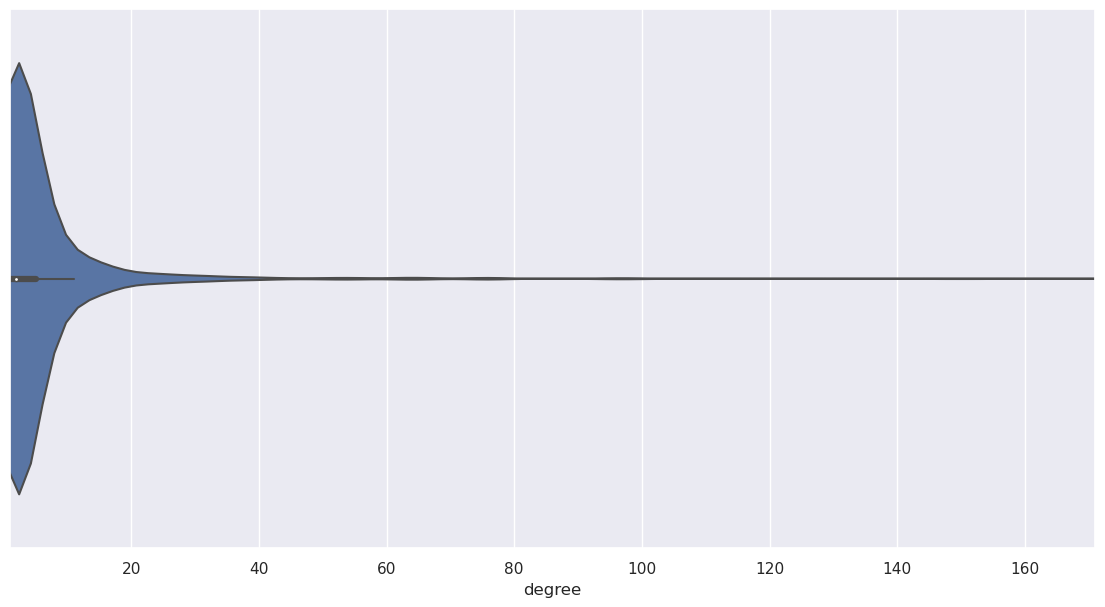

In [263]:
### Violinplot : densité des naissances dans le temps
#  https://mode.com/blog/violin-plot-examples/
#  https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot

sns.set_theme(style="whitegrid")

sns.set(rc={"figure.figsize":(14, 7)})

a = export['degree'].dropna()
lim_left=min(a)
lim_right=max(a)





ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=lim_left, right=lim_right)


In [264]:
kamo = nx.k_core(amO, k=5)

In [265]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
kamo.is_multigraph(),nx.is_connected(kamo) , kamo.number_of_nodes(), kamo.number_of_edges(), nx.density(kamo)


(False, True, 264, 1827, 0.052627030763912896)

In [266]:
components = nx.connected_components(kamo);
components_l = [len(c) for c in sorted(nx.connected_components(kamo), key=len, reverse=True)]
len(components_l), components_l[:5]

(1, [264])

In [267]:
largest_cc = max(nx.connected_components(kamo), key=len)

In [268]:
S = kamo.subgraph(largest_cc).copy()
type(S)


networkx.classes.graph.Graph

### Représenter le graphe

In [269]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html
u = S
## ,nx.is_connected(G_1971_1975) u.is_directed(),
u.is_multigraph(), nx.is_connected(u), u.number_of_nodes(), u.number_of_edges(), nx.density(u)


(False, True, 264, 1827, 0.052627030763912896)

In [270]:
list(u.nodes.data())[1:3]

[('Peking_University',
  {'degree': 17,
   'closeness': 0.32382521217472676,
   'betweenness': 0.0017884583299934273}),
 ('University_of_Madras',
  {'degree': 8,
   'closeness': 0.2899407456531947,
   'betweenness': 0.0010558476045447857})]

In [271]:
labels = {}
for i in list(u.nodes.data()):
    if i[1]['degree'] > 15:
        labels[i[0]]=i[0] 
list(labels.items())[:3]

[('Peking_University', 'Peking_University'),
 ('Cornell_University', 'Cornell_University'),
 ('Pennsylvania_State_University', 'Pennsylvania_State_University')]

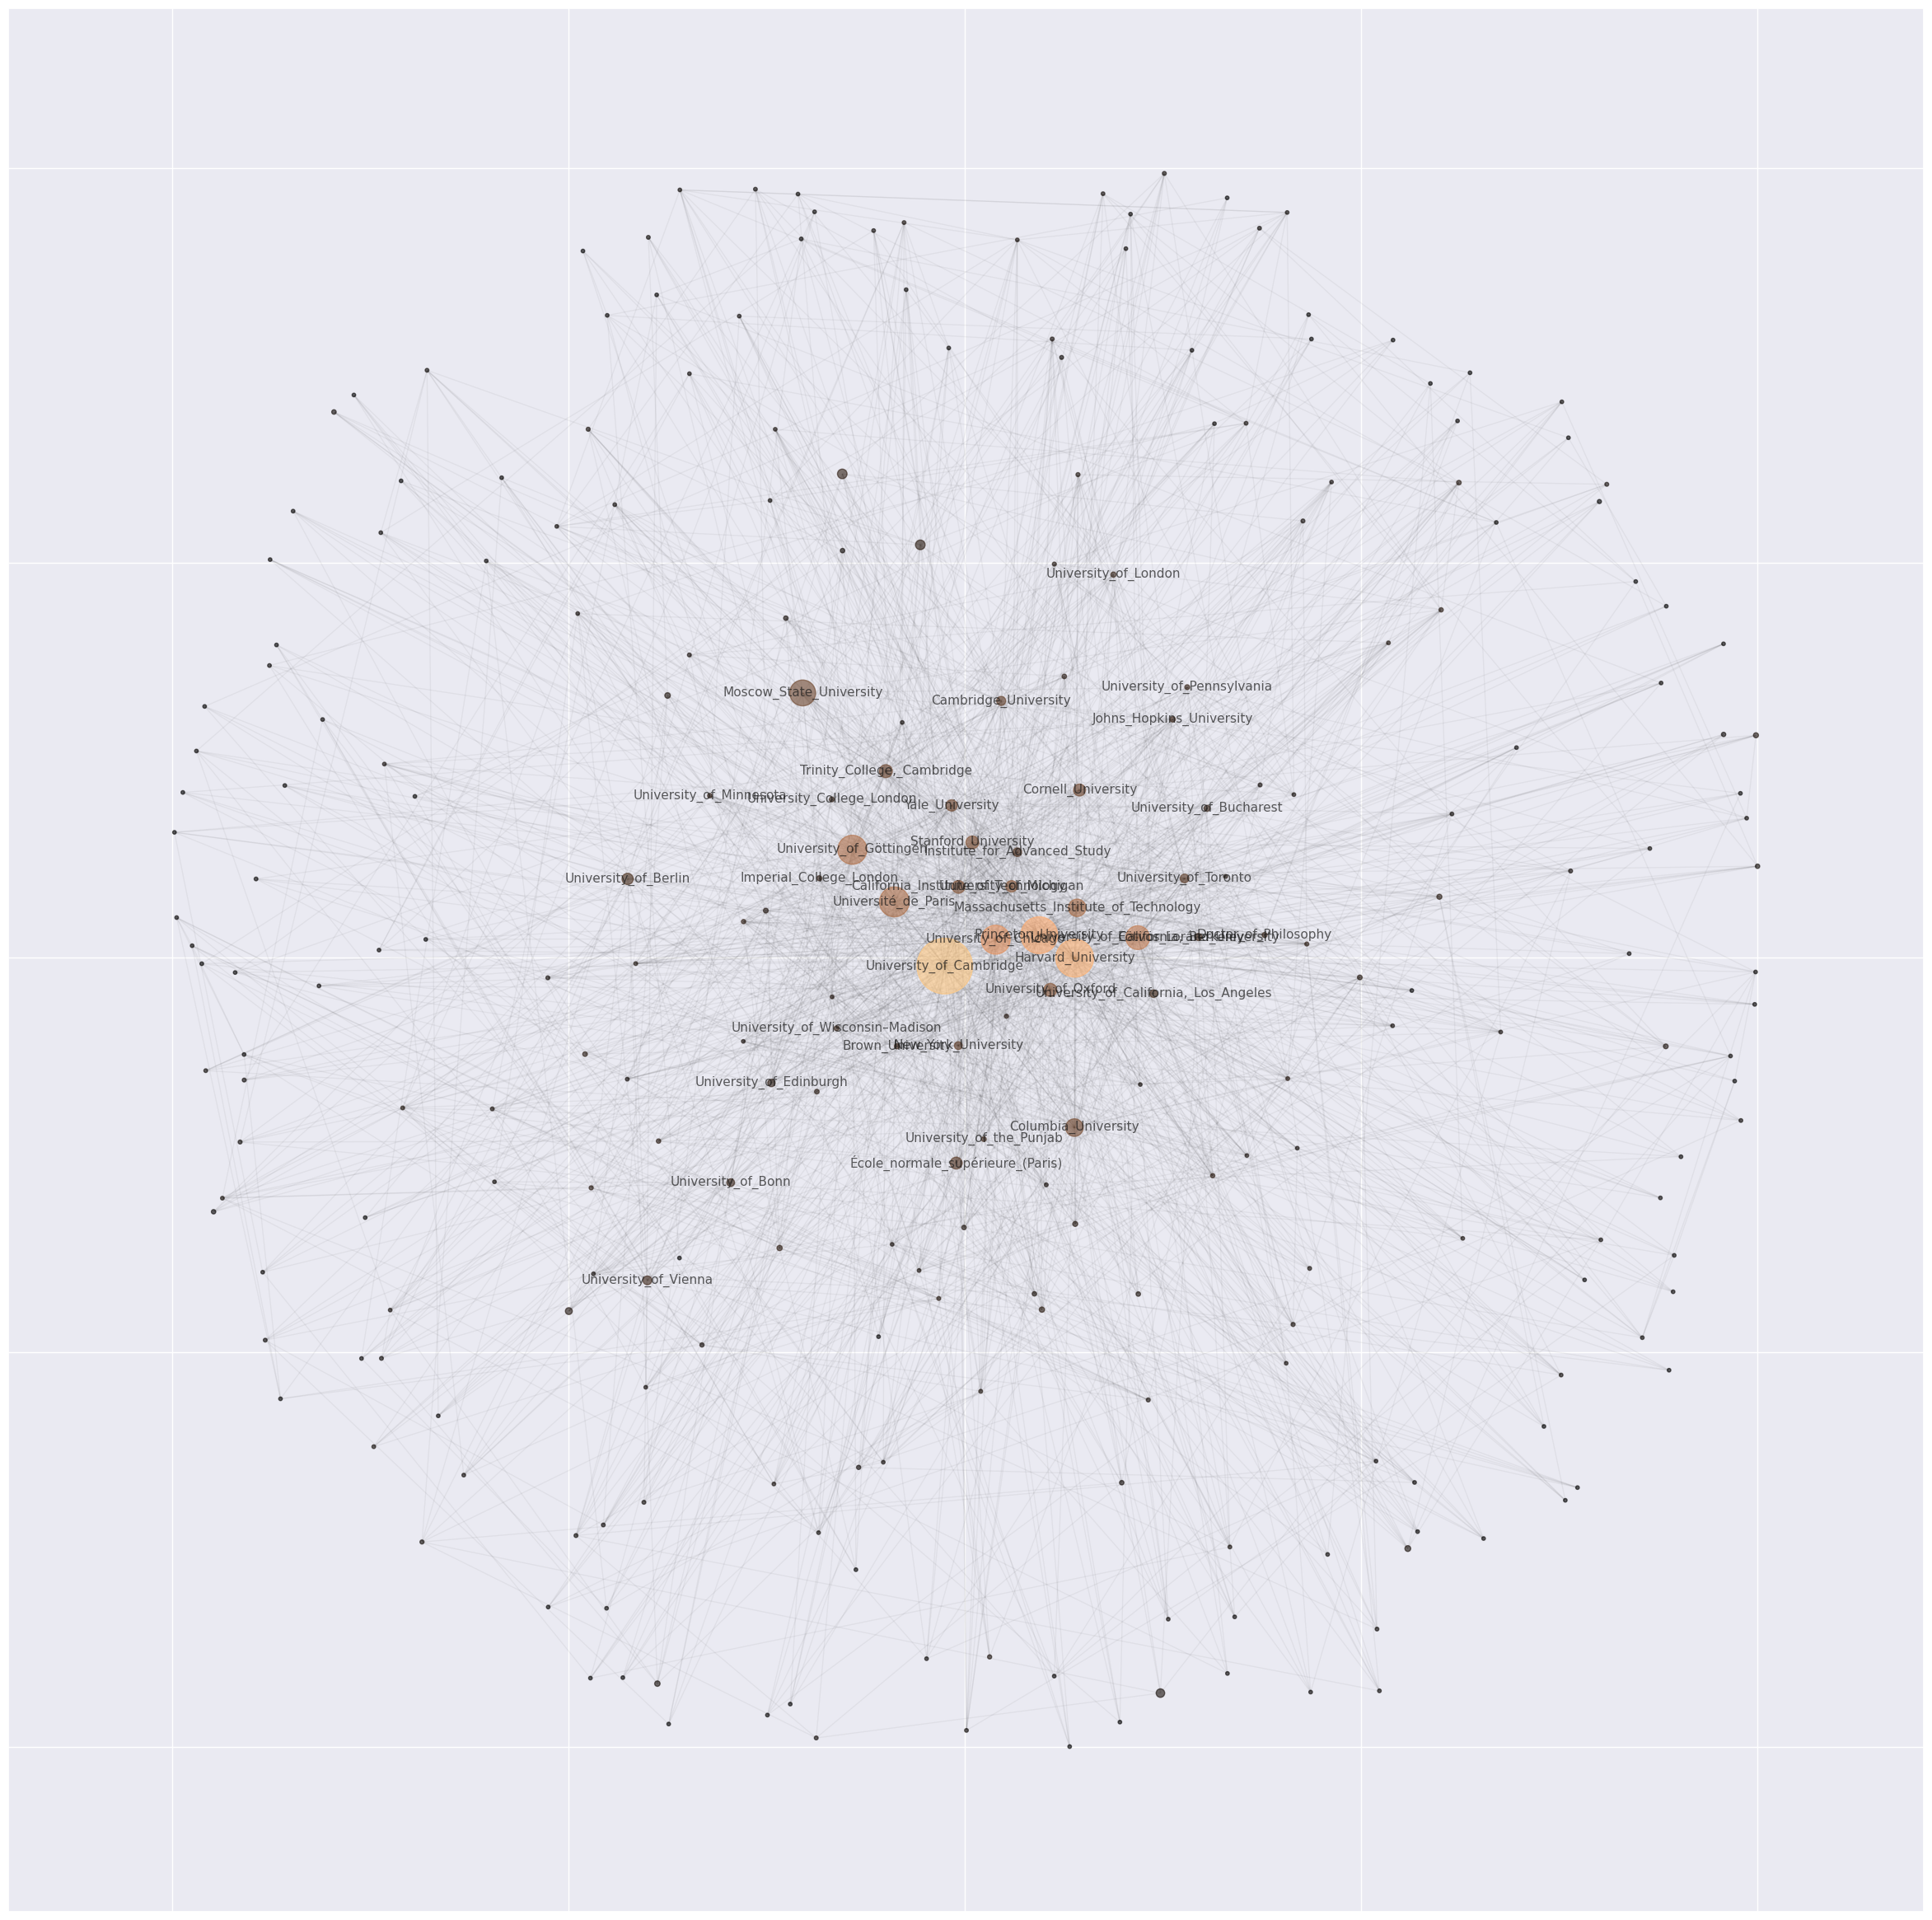

In [272]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (30,30))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
pos = nx.spring_layout(g, k=1)

labels = {}
for i in list(u.nodes.data()):
    if i[1]['degree'] > 30:
        labels[i[0]]=i[0] 

node_color = [i[1]['degree'] for i in list(u.nodes.data())]

### Adapter la taille des attribut à l'affichage
node_sizes = [i[1]['betweenness']**2 * 100000 + 10 for i in list(u.nodes.data())]


cp = 'grey'
nx.draw_networkx_nodes(g, pos, node_size=node_sizes, node_color=node_color, 
                      cmap='copper', alpha=0.6)
nx.draw_networkx_edges(g, pos, alpha=0.05) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=labels,  alpha=0.7, font_size=11)
#nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)

f = 'pictures/universites.svg'# io.BytesIO()

plt.savefig(f, format="svg")

plt.show()
